In [62]:
import pandas as pd
import numpy as np
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, train_test_split

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_colwidth", None) 

In [74]:
tweet_df = pd.read_csv('train.csv')
tweet_df = tweet_df[['text', 'target']]

In [75]:
tweet_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [76]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


In [77]:
tweet_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [78]:
stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ['http', 'https', 't.co', 'amp', '//t.co/']

stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [79]:
def process_tweet(tweet):
    tokens = nltk.word_tokenize(tweet)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    nonlist = ' '.join(stopwords_removed)
    return nonlist

In [80]:
tweet_df['processed_data'] = tweet_df['text'].map(process_tweet)
# tweet_df.drop('text', axis=1, inplace=True)
tweet_df.head()

,text,target,processed_data
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,residents asked 'shelter place notified officers evacuation shelter place orders expected
3,"13,000 people receive #wildfires evacuation orders in California",1,"13,000 people receive wildfires evacuation orders california"
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo ruby alaska smoke wildfires pours school


In [81]:
tweet_df['processed_data']=tweet_df['processed_data'].str.replace(r'(//t.co/)\w*', '')

In [82]:
tweet_df

,text,target,processed_data
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deeds reason earthquake may allah forgive us
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,residents asked 'shelter place notified officers evacuation shelter place orders expected
3,"13,000 people receive #wildfires evacuation orders in California",1,"13,000 people receive wildfires evacuation orders california"
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got sent photo ruby alaska smoke wildfires pours school
...,...,...,...
7608,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,two giant cranes holding bridge collapse nearby homes
7609,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,aria_ahrary thetawniest control wild fires california even northern part state troubling
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,m1.94 01:04 utc 5km volcano hawaii
7611,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,police investigating e-bike collided car little portugal e-bike rider suffered serious non-life threatening injuries


In [91]:
true_tweets = tweet_df[tweet_df['target']==1]['processed_data']
false_tweets = tweet_df[tweet_df['target']==0]['processed_data']

true_text = " ".join(tweet for tweet in true_tweets)
false_text = " ".join(tweet for tweet in false_tweets)

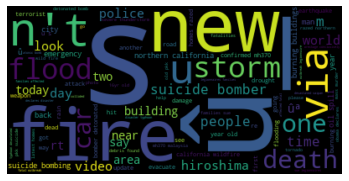

In [92]:
truecloud = WordCloud().generate(true_text)

plt.imshow(truecloud, interpolation='bilinear')
plt.axis('off')
plt.show();

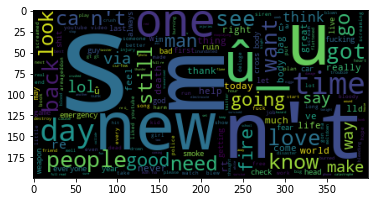

In [93]:
falsecloud = WordCloud().generate(false_text)

plt.imshow(falsecloud);

In [54]:
true_text

"deeds reason earthquake may allah forgive us forest fire near la ronge sask canada residents asked 'shelter place notified officers evacuation shelter place orders expected 13,000 people receive wildfires evacuation orders california got sent photo ruby alaska smoke wildfires pours school rockyfire update california hwy 20 closed directions due lake county fire cafire wildfires flood disaster heavy rain causes flash flooding streets manitou colorado springs areas 'm top hill see fire woods ... 's emergency evacuation happening building across street 'm afraid tornado coming area ... three people died heat wave far haha south tampa getting flooded hah- wait second live south tampa gon na gon na fvck flooding raining flooding florida tampabay tampa 18 19 days 've lost count flood bago myanmar arrived bago damage school bus 80 multi car crash breaking bbcmtd wholesale markets ablaze //t.co/lhyxeohy6c africanbaze breaking news nigeria flag set ablaze aba //t.co/2nndbgwyei inec office abia

In [33]:
total_vocab = set()
for tweet in tweet_df['processed_data']:
    total_vocab.update(tweet)
len(total_vocab)


78

In [9]:
# articles_concat = []
# for article in tweet_df['processed_data']:
#     articles_concat += article

In [10]:
# freq_dist = FreqDist(articles_concat) 
# freq_dist.most_common(200)

In [11]:
X = tweet_df['processed_data']
y = tweet_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=107, test_size=.2)



In [12]:
vectorizer = TfidfVectorizer()

train_vec = vectorizer.fit_transform(X_train)

test_vec = vectorizer.transform(X_test)

In [13]:
train_vec.shape
# (num_tweets, num_unique_words)

(6090, 18472)

In [14]:
rf_classifier = RandomForestClassifier(n_estimators=100)

In [15]:
rf_classifier.fit(train_vec, y_train)

RandomForestClassifier()

In [16]:
cross_val_score(rf_classifier,
               train_vec, y_train,
                cv=5)

array([0.79967159, 0.77093596, 0.78325123, 0.76765189, 0.75369458])

In [17]:
rf_classifier.score(test_vec, y_test)

0.7852921864740644